# Utilizando a biblioteca rasterio


O satélite Landsat 8 orbita a Terra em uma órbita quase polar, síncrona com o sol, a uma altitude de 705 km (438 mi) e circunda a Terra a cada 99 minutos. O satélite tem um ciclo de repetição de 16 dias com um tempo de travessia equatorial: 10h00 +/- 15 minutos.

Os dados do Landsat 8 são adquiridos no sistema de orbita/ponto do Worldwide Reference System-2 (WRS-2).A orbita e ponto  para San Diego são - 40, 37

O tamanho da cena para o satélite L8 é 170 km x 185 km (106 mi x 115 mi).

In [29]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

## Data source

s imagens do Landsat 8 estão disponíveis no Registro de opendata na AWS( https://registry.opendata.aws/landsat-8/ ). 

Os dados são organizados usando uma estrutura de diretórios com base nos dados de cada cena orbita e ponto (path and row). Por exemplo, os arquivos da cena Landsat LC08_L1TP_139045_20170304_20170316_01_T1 estão disponíveis no seguinte local: s3://landsat-pds/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/

O “c1” refere-se à Coleção 1, o “L8” refere-se ao Landsat 8, “139” refere-se a orbita da cena, “045” refere-se ao ponto da cena e o diretório final corresponde ao identificador do produto, que usa a seguinte nomenclatura convenção: LXSS_LLLL_PPPRRR_YYYYMMDD_yyymmdd_CC_TX, in which:

L = Landsat
X = Sensor
SS = Satellite
PPP = WRS path
RRR = WRS row
YYYYMMDD = Acquisition date
yyyymmdd = Processing date
CC = Collection number
TX = Collection category
Nesse caso, a cena corresponde ao caminho 139 do WRS, linha 045 do WRS, e foi tirada em 4 de março de 2017.

Um diretório de exemplo será: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html

Nesse caso, a cena corresponde ao caminho 139 do WRS, linha 045 do WRS, e foi tirada em 4 de março de 2017.

Um diretório de exemplo será:

| Band                                  |
|---------------------------------------|
| Band 1 - coastal aerosol              |
| Band 2 - blue                         |
| Band 3 - green                        |
| Band 4 - red                          |
| Band 5 - Near Infrared (NIR)          |
| Band 6 - Short-wave Infrared (SWIR) 1 |
| Band 7 - Short-wave Infrared (SWIR) 2 |
| Band 8 - Panchromatic                 |
| Band 9 - Cirrus                       |
| Band 10 - TIRS 1                      |
| Band 11 - TIRS 2                      |


The entire scene list (URLS to all directories of all paths and rows) is available at http://landsat-pds.s3.amazonaws.com/scene_list.gz or s3://landsat-pds/scene_list.gz. The structure of csv is :


| id   | productId                                | entityId              | acquisitionDate            | cloudCover | processingLevel | path | row | min_lat  | min_lon             | max_lat  | max_lon             | download_url                                                                                                     |   |
|------|------------------------------------------|-----------------------|----------------------------|------------|-----------------|------|-----|----------|---------------------|----------|---------------------|------------------------------------------------------------------------------------------------------------------|---|
| 4916 | LC08_L1TP_040037_20170330_20170414_01_T1 | LC80400372017089LGN00 | 2017-03-30 18:22:08.295500 | 17.73      | L1TP            | 40   | 37  | 32.10751 | -118.42548000000001 | 34.22299 | -115.94958999999999 | https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20170330_20170414_01_T1/index.html |   |


## Processe imagens usando rasterio - Estude os dados

Vamos abrir as duas imagens que baixamos, usando rasterio. O objeto retornado é um objeto **DatasetReader**. Ele contém muitos metadados relacionados à imagem. Alguns dos parâmetros fornecem bons insights para a tarefa em mãos.

### Tiled
Os dados são lado a lado?

In [30]:
# Reference - https://rasterio.readthedocs.io/en/stable/quickstart.html
reader_red = rasterio.open('data/red.tif')
print(reader_red.is_tiled)

reader_nir = rasterio.open('data/nir.tif')
print(reader_nir.is_tiled)

True
True


### Quantas bandas há na imagem?

In [5]:
reader_red.count

1

Baixamos a faixa vermelha. A contagem confirma que a imagem tem apenas uma banda.

### Qual é o tamanho de cada bloco (próprio tiled, conforme meu entendimento) ?

In [31]:
reader_red.block_shapes

[(512, 512)]

A imagem tem muitos blocos com cada bloco com tamanho 512 x 512
### Qual é o tamanho da imagem da banda?

In [32]:
print(reader_red .width)
print(reader_red.height)


7691
7821


O perfil do leitor de conjunto de dados fornecerá todos esses detalhes em um dicionário abrangente de valores.

In [8]:
reader_red.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7691, 'height': 7821, 'count': 1, 'crs': None, 'transform': Affine(30.0, 0.0, 367785.0,
       0.0, -30.0, 3787815.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

## Retangulo envolvente

A opção de limites mostrará a referência espacial. Cada pixel na imagem raster está dentro de uma caixa delimitadora retangular no mundo. A imagem do landsat abaixo cobre o mundo de 367785 metros a 598515 metros da esquerda para a direita e 3787815. 0 metros a 3553185 metros de cima para baixo. Isso cobre 230,73 km x 234,63 km.

In [9]:
reader_red.bounds

BoundingBox(left=367785.0, bottom=3553185.0, right=598515.0, top=3787815.0)

Os limites acima também podem ser derivados de uma matriz de transformação afim, conforme mostrado abaixo. Uma transformação afim preserva a colinearidade entre dois pontos e as razões das distâncias. Mas não preserva os ângulos.

 ( Refer - http://mathworld.wolfram.com/AffineTransformation.html ).


In [10]:
reader_red.transform

Affine(30.0, 0.0, 367785.0,
       0.0, -30.0, 3787815.0)

Esta matriz pode ser usada para encontrar o mapeamento entre a posição do pixel na imagem e a coordenada (x,y) no solo. Basta multiplicar a posição do pizel pela matriz afim. Por exemplo,
o canto superior esquerdo da caixa delimitadora pode ser calculado multiplicando a matriz de transformação por (0,0)

In [11]:
reader_red.transform * (0, 0)

(367785.0, 3787815.0)

In [12]:
#Find the (x,y) coordinate of bottm right corner
reader_red.transform * (reader_red.width, reader_red.height)

(598515.0, 3553185.0)

Qual é o ponto de referência a partir do qual esses medidores são medidos? A resposta é CRS - sistema de referência de coordenadas. Nosso arquivo usa EPSG para a referência de coordenadas.

In [13]:
reader_red.crs

EPSG 32611 é banda na América do Norte. Veja a foto.

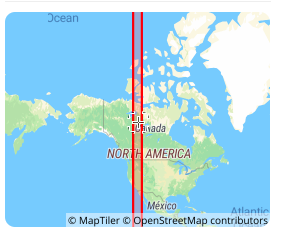

Conhecer o sistema de referência de coordenadas e os valores nos ajuda a traduzir as posições para diferentes formatos e especificações de localização como (orbita, ponto), (latitude, longitude) etc.

Da documentação do rasterio:
"O "EPSG 32612" identifica um sistema de referência de coordenadas específico: zona UTM 12N. Este sistema é usado para mapeamento
áreas no Hemisfério Norte entre 108 e 114 graus oeste. O canto superior esquerdo do conjunto de dados de exemplo,
(358485.0, 4265115.0), está 141,5 quilômetros a oeste do meridiano central da zona 12 (111 graus oeste) e 4265
quilômetros ao norte do equador"

In [14]:
#import xarray as xr
#red = xr.open_rasterio('data/red.tif', chunks={'band': 1, 'x': 512, 'y': 512})
#red = xr.open_rasterio('data/red.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
#nir = xr.open_rasterio('data/nir.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
#print(red)
#print(red.variable.data)

In [15]:
red = reader_red.read(1) # 1 is the band number. 
#If there were more than one band, they could be accessed by changing the number.
nir = reader_nir.read(1)

## Coordenadas espaciais para linha-coluna e vice-versa

Para isso, voltemos à caixa delimitadora. Use os atributos superior, esquerdo, direito e inferior junto com
deslocamentos para especificar a coordenada geoespacial para um ponto. Em seguida, use o método index() para converter essa coordenada na linha e coluna da matriz de dados raster, conforme mostrado:

Ícone "Verificada pela comunidade"


In [16]:
x, y = (reader_red.bounds.left + 100000, reader_red.bounds.top - 50000)
row, col = reader_red.index(x, y)
print(row, col)
red[row, col]

1666 3333


13118

Ao contrário, para converter uma (linha, coluna) da matriz raster para geoespacial(x,y), chame a função xy()

In [17]:
row, col = (0,0) #very first pixel in the image.
x, y = reader_red.xy(row, col)
x,y

(367800.0, 3787800.0)

## Visualização

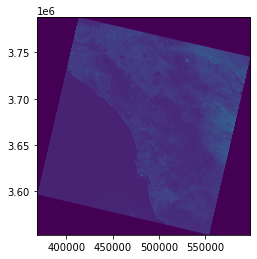

<AxesSubplot:>

In [18]:
from rasterio.plot import show # import the show function which allows us to display the image

#print("Image dimensions: ", img.shape)
show(red, transform=reader_red.transform)

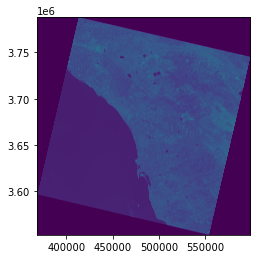

<AxesSubplot:>

In [19]:
show(nir, transform=reader_nir.transform)

## Calculo do NDVI usando Bandas do NIR e Red 

In [20]:
ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
#ndvi=np.where((nir+red) == 0, 0, (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
#)

C:\Users\User\AppData\Local\Temp\ipykernel_4500\3064422038.py:1: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))


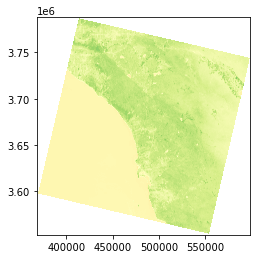

<AxesSubplot:>

In [21]:
show(ndvi, transform=reader_red.transform, cmap='RdYlGn')

## NDVI Após correção atmosférica

Vamos tentar calcular o NDVI depois de remover a reflexão atmosférica.

In [22]:
def load_scale_factors(filename, band_number):
    with open(filename) as f:
        data = f.read()
        #print(data)
        # metadata = json.dump(data)
        ''' M_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
            A_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
         '''
        #hard cording the above values from the meta data file for now
        M_p = 2.0000E-05
        A_p = -0.100000
    return M_p, A_p
def calculate_reflectance(ds, band_number, metafile='data/LC08_L1TP_040037_20170415_20170501_01_T1_MTL.txt'):
    M_p, A_p = load_scale_factors(metafile, band_number)
    toa = M_p * ds + A_p
    return toa


In [23]:
red_toa = calculate_reflectance(red, band_number=4)
nir_toa = calculate_reflectance(nir, band_number=5)


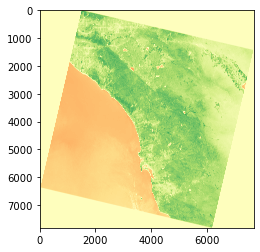

In [24]:
#Calculate NDVI Again
ndvi = (nir_toa - red_toa) / (nir_toa + red_toa)
#ndvi2d = ndvi.squeeze()
plt.figure()
#im = ndvi2d.compute().plot.imshow( vmin=-1, vmax=1,cmap='RdYlGn')
plt.imshow(ndvi, vmin=-1, vmax=1, cmap='RdYlGn')
#plt.axis('equal')
#plt.show()
